In [1]:
# Install the Prophet
!pip install prophet

In [2]:
# Import the required libraries and dependencies
import pandas as pd
import datetime as dt
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from prophet import Prophet
import yfinance as yf
import os
import csv

In [3]:
import warnings
# Ignore warnings
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning)

In [4]:
# Set crypto variable
crypto = 'BNB'
yf_crypto = 'BNB'

# Set YF crypto symbol
symbol = f'{yf_crypto}-USD'

# Create crypto df
#crypto_df = f'{crypto}_df'.lower()

In [5]:
# Retreive max data
data = yf.Ticker(f'{symbol}')
history = data.history(period='max')

# Define file path and name
#filepath = f'~/crypto-forecast/resources/{crypto}-USD.csv'
#filepath = os.path.expanduser('~/crypto-forecast/resources/ADA-USD.csv')

# Create dataframe
crypto_df = pd.DataFrame(history)

# Set 'Date' as the index and parse dates
crypto_df.index = pd.to_datetime(crypto_df.index)

# Drop columns
crypto_df.drop(columns=['Dividends', 'Stock Splits'], inplace=True)

# Drop last row
crypto_df = crypto_df.drop(crypto_df.tail(1).index)

# Drop rows with any NaN values
crypto_df.dropna(inplace=True)

# Sort by ascending date
crypto_df = crypto_df.sort_values(by="Date", ascending=True)

# Drop timezone from datetime
crypto_df = crypto_df.reset_index()
crypto_df['Date'] = crypto_df['Date'].dt.tz_localize(None)
crypto_df.set_index('Date', inplace=True)

# Set file path to store data as a csv
csv_filepath = os.path.expanduser(f'~/crypto-forecast/resources/{crypto}-USD.csv')

# Write the DataFrame to a CSV file
crypto_df.to_csv(csv_filepath, index=True)

# Review the first and last five rows of the DataFrame
display(crypto_df.head())
display(crypto_df.tail())

,Open,High,Low,Close,Volume
Date,,,,,
2017-11-09,2.05314,2.17423,1.89394,1.99077,19192200
2017-11-10,2.00773,2.06947,1.64478,1.79684,11155000
2017-11-11,1.78628,1.91775,1.61429,1.67047,8178150
2017-11-12,1.66889,1.67280,1.46256,1.51969,15298700
2017-11-13,1.52601,1.73502,1.51760,1.68662,12238800


,Open,High,Low,Close,Volume
Date,,,,,
2024-06-04,626.432983,687.403809,625.264954,686.201416,3416994948
2024-06-05,686.201416,712.588379,685.777100,698.889404,3501231414
2024-06-06,698.889404,720.672607,692.994751,710.464050,2997888288
2024-06-07,710.460388,710.838501,665.180176,683.360962,2987033806
2024-06-08,683.368591,694.312805,678.645813,682.665161,1966216051


In [6]:
# Get last closing price
last_close_df = crypto_df.iloc[-1]
last_close_price = last_close_df['Close']
last_close_price

682.6651611328125

In [7]:
crypto_df.corr()

,Open,High,Low,Close,Volume
Open,1.000000,0.998981,0.998393,0.997896,0.641518
High,0.998981,1.000000,0.997731,0.998952,0.661946
Low,0.998393,0.997731,1.000000,0.998818,0.620929
Close,0.997896,0.998952,0.998818,1.000000,0.646088
Volume,0.641518,0.661946,0.620929,0.646088,1.000000


In [8]:
# Create new df with just Close prices and Volume
df_close = crypto_df[['Close', 'Volume']]

In [9]:
df_close.name = 'Close'
df_close

,Close,Volume
Date,,
2017-11-09,1.990770,19192200
2017-11-10,1.796840,11155000
2017-11-11,1.670470,8178150
2017-11-12,1.519690,15298700
2017-11-13,1.686620,12238800
...,...,...
2024-06-04,686.201416,3416994948
2024-06-05,698.889404,3501231414
2024-06-06,710.464050,2997888288


In [10]:
# Create a copy of the DataFrame to avoid the SettingWithCopyWarning
df_close_ma = df_close.copy()

# Calculate volatility
df_close_ma.loc[:, 'Percent Change'] = df_close_ma['Close'].pct_change()*100
df_close_ma.loc[:, 'Volatility'] = df_close_ma['Percent Change'].rolling(10).std(ddof=0) * np.sqrt(252)

# Calculate 10-day Simple Moving Average (SMA)
df_close_ma.loc[:, 'SMA10'] = df_close_ma['Close'].rolling(10).mean()

# Calculate 30-day Simple Moving Average (SMA)
df_close_ma.loc[:, 'SMA30'] = df_close_ma['Close'].rolling(30).mean()

# Calculate 50-day Simple Moving Average (SMA)
df_close_ma.loc[:, 'SMA50'] = df_close_ma['Close'].rolling(50).mean()

# Remove NULL values
df_close_ma.dropna(inplace=True)

In [11]:
# Review the first and last five rows of the DataFrame
display(df_close_ma.head())
display(df_close_ma.tail())

,Close,Volume,SMA10,SMA30,SMA50
Date,,,,,
2017-12-28,9.32141,109298000,6.562748,4.183277,3.186518
2017-12-29,8.80760,70849400,6.864275,4.418480,3.322854
2017-12-30,7.84101,72933904,7.130755,4.613281,3.443738
2017-12-31,8.63558,74927904,7.476312,4.832126,3.583040
2018-01-01,8.41461,66422800,7.884158,5.043141,3.720938


,Close,Volume,SMA10,SMA30,SMA50
Date,,,,,
2024-06-04,686.201416,3416994948,610.505200,596.932926,590.482620
2024-06-05,698.889404,3501231414,620.411548,600.613375,593.703821
2024-06-06,710.464050,2997888288,631.105310,605.045970,597.224781
2024-06-07,683.360962,2987033806,639.320081,608.218087,599.848558
2024-06-08,682.665161,1966216051,648.089392,611.105859,602.404076


<Axes: xlabel='Date'>

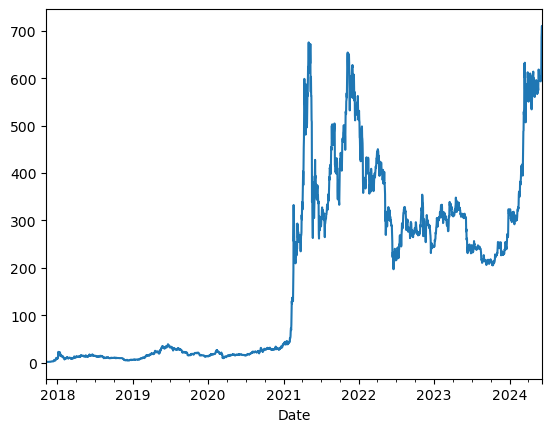

In [12]:
# Plot Close
df_close['Close'].plot()

In [13]:
## Create a Time Series Model with Prophet

In [14]:
# Using the DataFrame, reset the index so the date information is no longer the index
df_close = df_close.reset_index()

In [15]:
# Label the columns ds and y so that the syntax is recognized by Prophet
df_close.rename(columns={'Date':'ds','Close':'y'}, inplace=True)

# Drop an NaN values from the prophet_df DataFrame
df_close.dropna()

# View the first and last five rows of the DataFrame
df_close

,ds,y,Volume
0,2017-11-09,1.990770,19192200
1,2017-11-10,1.796840,11155000
2,2017-11-11,1.670470,8178150
3,2017-11-12,1.519690,15298700
4,2017-11-13,1.686620,12238800
...,...,...,...
2399,2024-06-04,686.201416,3416994948
2400,2024-06-05,698.889404,3501231414
2401,2024-06-06,710.464050,2997888288
2402,2024-06-07,683.360962,2987033806


In [16]:
# Call the Prophet function, store as an object
crypto_model = Prophet()

In [17]:
# Fit the time-series model.
crypto_model.fit(df_close)

16:37:00 - cmdstanpy - INFO - Chain [1] start processing
16:37:00 - cmdstanpy - INFO - Chain [1] done processing


In [18]:
# Create a future dataframe to hold predictions
# Make the prediction go out 30 days
crypto_future = crypto_model.make_future_dataframe(periods = 90, freq = 'd')

# View the last five rows of the DataFrame
crypto_future.tail(5)

,ds
2489,2024-09-02
2490,2024-09-03
2491,2024-09-04
2492,2024-09-05
2493,2024-09-06


In [19]:
# Make the predictions for the data using the DataFrame
crypto_forecast = crypto_model.predict(crypto_future)

# Display the first five rows of the DataFrame
crypto_forecast.tail(30)

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
2464,2024-08-08,463.771213,363.838473,521.222422,457.401949,471.884447,-21.967689,-21.967689,-21.967689,0.179010,0.179010,0.179010,-22.146699,-22.146699,-22.146699,0.0,0.0,0.0,441.803524
2465,2024-08-09,464.197150,364.369415,521.503841,457.564197,472.509412,-20.359657,-20.359657,-20.359657,0.446607,0.446607,0.446607,-20.806264,-20.806264,-20.806264,0.0,0.0,0.0,443.837493
2466,2024-08-10,464.623086,372.479406,521.743129,457.810565,473.123298,-19.339565,-19.339565,-19.339565,0.100660,0.100660,0.100660,-19.440225,-19.440225,-19.440225,0.0,0.0,0.0,445.283521
2467,2024-08-11,465.049023,375.166207,528.922546,458.061446,473.695831,-18.166824,-18.166824,-18.166824,-0.094223,-0.094223,-0.094223,-18.072601,-18.072601,-18.072601,0.0,0.0,0.0,446.882199
2468,2024-08-12,465.474960,373.763831,525.396399,458.283088,474.293037,-17.188703,-17.188703,-17.188703,-0.460546,-0.460546,-0.460546,-16.728157,-16.728157,-16.728157,0.0,0.0,0.0,448.286257
2469,2024-08-13,465.900896,373.459438,533.101291,458.412005,474.914729,-15.830111,-15.830111,-15.830111,-0.398326,-0.398326,-0.398326,-15.431785,-15.431785,-15.431785,0.0,0.0,0.0,450.070785
2470,2024-08-14,466.326833,375.306322,530.679763,458.775478,475.584759,-13.981067,-13.981067,-13.981067,0.226816,0.226816,0.226816,-14.207884,-14.207884,-14.207884,0.0,0.0,0.0,452.345766
2471,2024-08-15,466.752770,377.734311,532.738186,459.072866,476.254788,-12.900741,-12.900741,-12.900741,0.179010,0.179010,0.179010,-13.079751,-13.079751,-13.079751,0.0,0.0,0.0,453.852028
2472,2024-08-16,467.178706,381.010277,534.703481,459.325720,476.924817,-11.622408,-11.622408,-11.622408,0.446607,0.446607,0.446607,-12.069015,-12.069015,-12.069015,0.0,0.0,0.0,455.556298
2473,2024-08-17,467.604643,380.577791,529.336493,459.579553,477.637431,-11.094448,-11.094448,-11.094448,0.100660,0.100660,0.100660,-11.195108,-11.195108,-11.195108,0.0,0.0,0.0,456.510195


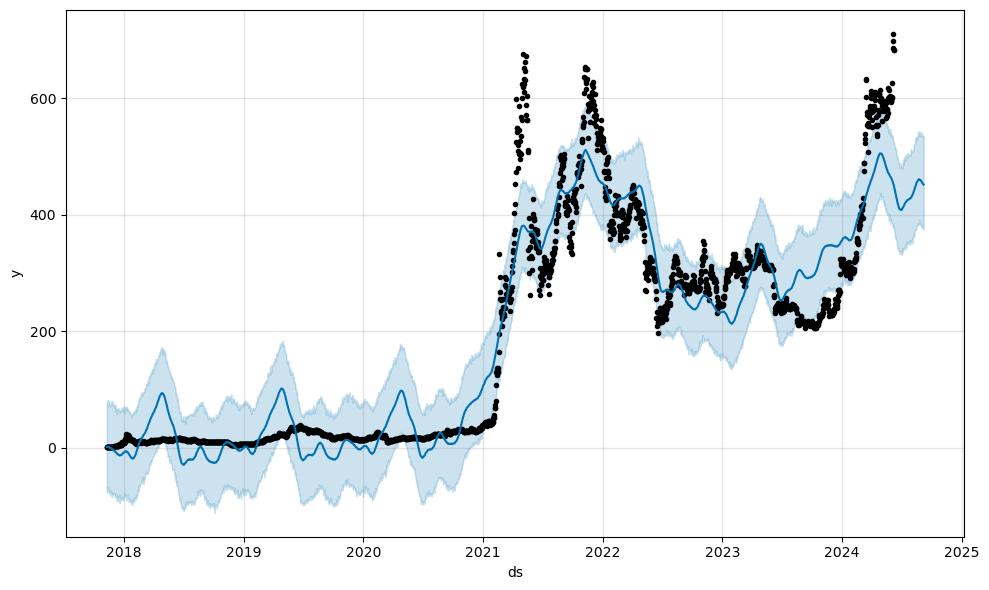

In [20]:
# Plot the Prophet predictions for the data
crypto_model.plot(crypto_forecast)
plt.savefig(f'{crypto}_forecast', bbox_inches = 'tight')

In [21]:
# Set the index in the forecast DataFrame to the ds datetime column
crypto_forecast = crypto_forecast.set_index('ds')

In [22]:
# View only the yhat,yhat_lower and yhat_upper columns from the forecast DataFrame
crypto_forecast[['yhat', 'yhat_lower', 'yhat_upper']].iloc[-90:,:]

,yhat,yhat_lower,yhat_upper
ds,,,
2024-06-09,445.401045,370.164042,520.830497
2024-06-10,442.510283,368.437717,518.098588
2024-06-11,439.956476,359.543137,511.927854
2024-06-12,437.897813,361.484672,515.058652
2024-06-13,435.125115,361.375639,513.564984
...,...,...,...
2024-09-02,454.669058,378.531929,534.404400
2024-09-03,453.778809,377.658731,534.902818
2024-09-04,453.458890,378.871639,533.496168


In [23]:
# Rename columns
crypto_forecast.rename(columns={'yhat':'mid trend price','yhat_lower':'lower trend price','yhat_upper':'upper trend price'}, inplace=True)

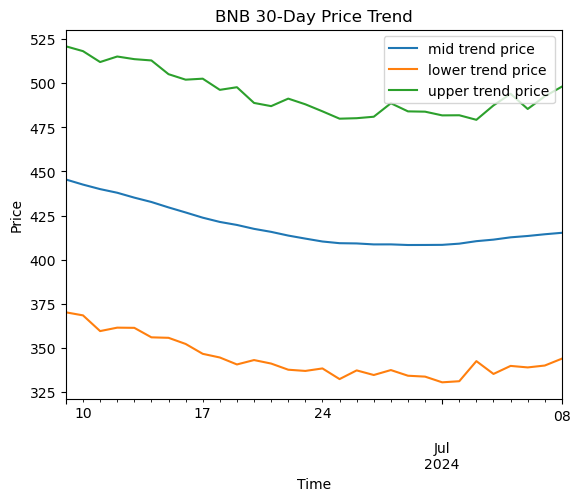

In [24]:
# From the forecast DataFrame, plot the data to visualize
# the yhat, yhat_lower, and yhat_upper columns over the last 30 days
crypto_forecast[['mid trend price', 'lower trend price', 'upper trend price']].iloc[-90:-60,:].plot()
plt.xlabel('Time')
plt.ylabel('Price')
plt.title(f'{crypto} 30-Day Price Trend')    
plt.show()

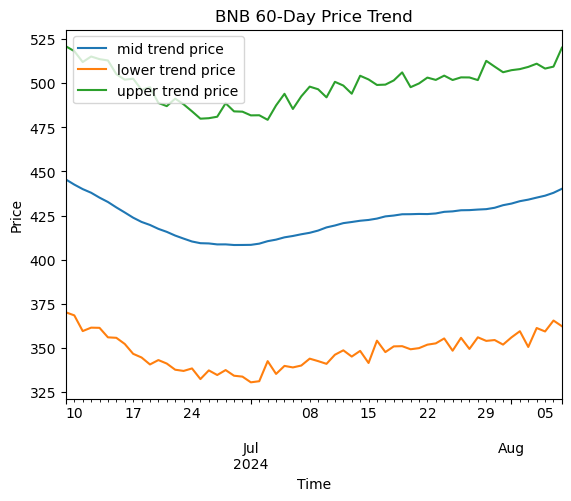

In [25]:
# From the forecast DataFrame, plot the data to visualize
# the yhat, yhat_lower, and yhat_upper columns over the last 30 days
crypto_forecast[['mid trend price', 'lower trend price', 'upper trend price']].iloc[-90:-30,:].plot()
plt.xlabel('Time')
plt.ylabel('Price')
plt.title(f'{crypto} 60-Day Price Trend')    
plt.show()

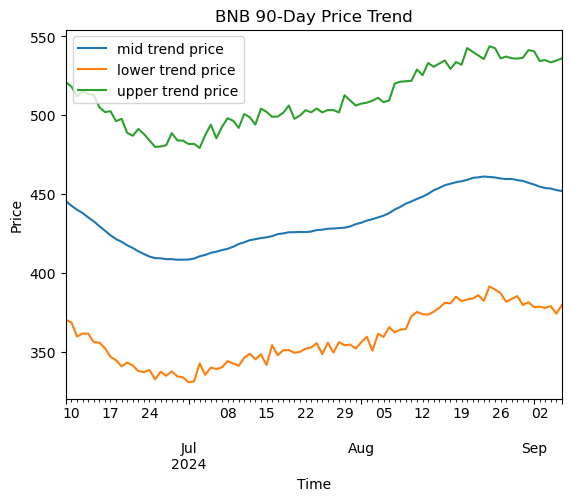

In [26]:
# From the forecast DataFrame, plot the data to visualize
# the yhat, yhat_lower, and yhat_upper columns over the last 30 days
crypto_forecast[['mid trend price', 'lower trend price', 'upper trend price']].iloc[-90:,:].plot()
plt.xlabel('Time')
plt.ylabel('Price')
plt.title(f'{crypto} 90-Day Price Trend')    
plt.savefig(f'{crypto}_90d_trend_forecast', bbox_inches = 'tight')
plt.show()

In [27]:
# Retrieve last closing price
last_close_price

682.6651611328125

In [28]:
# Retreive tomorrow's mid trend price forecast
tommorow_mid_trend_price = crypto_forecast['mid trend price'].iloc[-90]
tommorow_mid_trend_price

445.4010445155161

In [29]:
# Calculate tommorrow's weighted price
wp = last_close_price*.5 + tommorow_mid_trend_price*.5
wp

564.0331028241643

In [30]:
# Retreive tomorrow's weighted trend price forecast
tommorow_mid_trend_price = ((crypto_forecast['mid trend price'].iloc[-90]*.6)+(crypto_forecast['upper trend price'].iloc[-90]*.2)+(crypto_forecast['lower trend price'].iloc[-90]*.2))
tommorow_mid_trend_price

445.43953438524596

In [31]:
# Retrieve weighted trend price in 30 days
mid_trend_price_in_30 = ((crypto_forecast['mid trend price'].iloc[-60]*.6)+(crypto_forecast['upper trend price'].iloc[-60]*.2)+(crypto_forecast['lower trend price'].iloc[-60]*.2))
mid_trend_price_in_30

417.6909057428562

In [32]:
# Retrieve weighted trend price in 60 days
mid_trend_price_in_60 = ((crypto_forecast['mid trend price'].iloc[-30]*.6)+(crypto_forecast['upper trend price'].iloc[-30]*.2)+(crypto_forecast['lower trend price'].iloc[-30]*.2))
mid_trend_price_in_60

442.0942932720523

In [33]:
# Retrieve weighted trend price in 90 days
mid_trend_price_in_90 = ((crypto_forecast['mid trend price'].iloc[-1]*.6)+(crypto_forecast['upper trend price'].iloc[-1]*.2)+(crypto_forecast['lower trend price'].iloc[-1]*.2))
mid_trend_price_in_90

454.25775254385337

In [34]:
# Calculate expected gain/loss between mid trend price in 30 days and last close price
#percent_diff_30 = ((mid_trend_price_in_30)/(last_close_price))-1
percent_diff_30 = ((mid_trend_price_in_30)/(wp))-1
percent_diff_30.round(3)

-0.259

In [35]:
# Calculate expected gain/loss between mid trend price in 60 days and last close price
#percent_diff_60 = ((mid_trend_price_in_60)/(last_close_price))-1
percent_diff_60 = ((mid_trend_price_in_60)/(wp))-1
percent_diff_60.round(3)

-0.216

In [36]:
# Calculate expected gain/loss between mid trend price in 90 days and last close price
#percent_diff_90 = ((mid_trend_price_in_90)/(last_close_price))-1
percent_diff_90 = ((mid_trend_price_in_90)/(wp))-1
percent_diff_90.round(3)

-0.195

In [37]:
# Reset the index in the forecast DataFrame
crypto_forecast = crypto_forecast.reset_index()

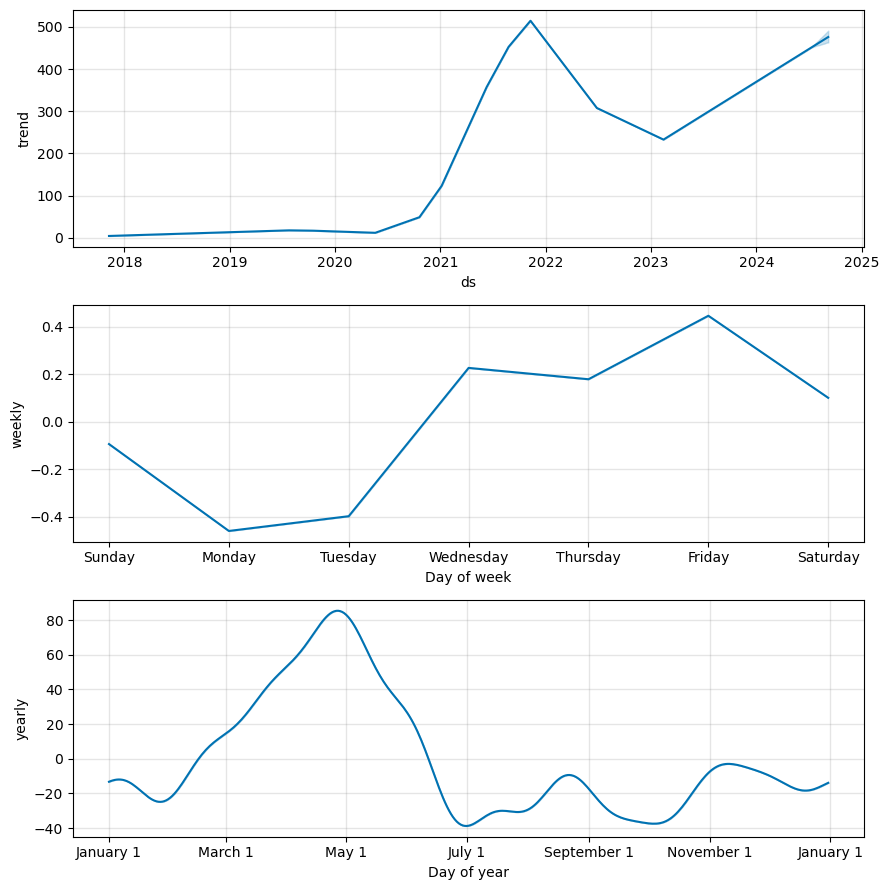

In [38]:
# Use the plot_components function to visualize the forecast results
# for the forecast DataFrame
fig_comp = crypto_model.plot_components(crypto_forecast)
plt.savefig(f'{crypto}_components.png', bbox_inches = 'tight')

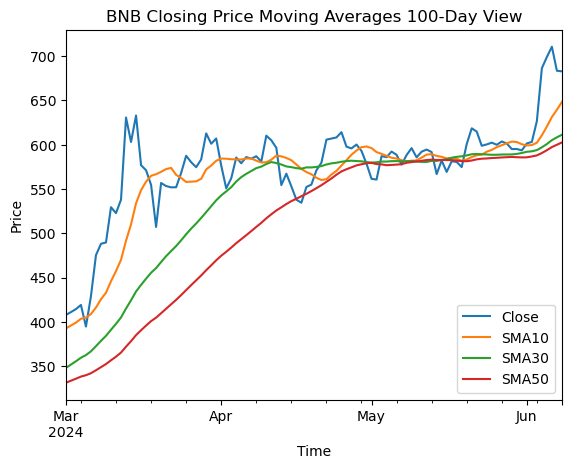

In [39]:
df_last_100 = df_close_ma.iloc[-100:]
df_last_100[['Close', 'SMA10', 'SMA30', 'SMA50']].plot()
plt.xlabel('Time')
plt.ylabel('Price')
plt.title(f'{crypto} Closing Price Moving Averages 100-Day View')    
plt.show()

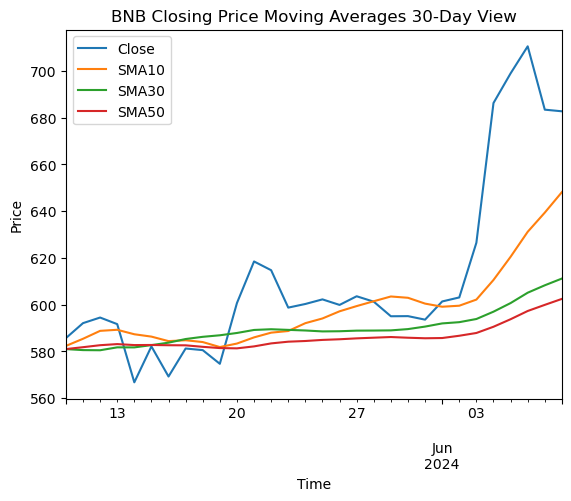

In [40]:
df_last_100 = df_close_ma.iloc[-30:]
df_last_100[['Close', 'SMA10', 'SMA30', 'SMA50']].plot()
plt.xlabel('Time')
plt.ylabel('Price')
plt.title(f'{crypto} Closing Price Moving Averages 30-Day View') 
plt.savefig(f'{crypto}_30d_MA_view.png', bbox_inches = 'tight')
plt.show()

In [41]:
# import module
from datetime import datetime
 
# get current date and time
current_datetime = datetime.now().strftime("%Y-%m-%d")
print("Current date & time : ", current_datetime)
 
# convert datetime obj to string
str_current_datetime = str(current_datetime)
 
# create a file object along with extension
#file_name = f'{crypto} '+str_current_datetime+".txt"
file_name = str_current_datetime+".csv"
file = open(file_name, 'a')
 
print("File created : ", file.name)
file.close()

Current date & time :  2024-06-09
File created :  2024-06-09.csv


In [42]:
f = open(f'{file_name}', "a")
f.writelines([f'{crypto},{last_close_price},{percent_diff_30},{percent_diff_60},{percent_diff_90}\n'])
f.close()

In [43]:
f = open(f'{file_name}', "r")
print(f.read())

ADA,0.43657100200653076,-0.07364667494769794,-0.0009456964793739253,0.3544596118546628
ADA,0.43657100200653076,-0.08437373181845453,0.002834181787628731,0.36173019111251126
ADA,0.43657100200653076,-0.08372637062435029,0.0025919668069758206,0.3631142967037635
ADA,0.43657100200653076,-0.0783190338427533,0.004381382002310641,0.36321329122708335
ATOM,7.759523868560791,-0.2525451407294217,-0.22995154564524733,0.08676291965413196
AVAX,32.29003143310547,-0.06238204683353343,0.016250905637703372,0.184324988794629
AVAX,32.29003143310547,-0.061383912293528464,0.006255814491331391,0.188757389641659
BNB,682.6651611328125,-0.25945675235825627,-0.21619087415535265,-0.19462572272913758

